In [2]:
!python3 -m ensurepip --upgrade

StatementMeta(69af5b35-48d0-49fe-8597-e33f401a392d, 0, 7, Finished, Available, Finished)

/usr/bin/python3: No module named ensurepip


In [ ]:
# Step 0: Install Required Libraries
!pip3 install yfinance pandas matplotlib statsmodels


StatementMeta(, , -1, Waiting, , Waiting)

In [1]:
# Step 1: Import Libraries
import yfinance as yf
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')


StatementMeta(69af5b35-48d0-49fe-8597-e33f401a392d, 2, 6, Finished, Available, Finished)

In [2]:
# Step 2: Define stock and forecast settings (Azure-safe, no interactive input)
ticker = "AAPL"  # ← Set your desired stock symbol
start_date = "2024-01-01"  # ← Change to your preferred start
end_date = "2025-02-28"    # ← Change to your preferred end
forecast_steps = 30        # ← Number of future business days to forecast

print(f"Forecasting {forecast_steps} days for: {ticker} ({start_date} to {end_date})")


StatementMeta(69af5b35-48d0-49fe-8597-e33f401a392d, 2, 7, Finished, Available, Finished)

Forecasting 30 days for: AAPL (2024-01-01 to 2025-02-28)


In [3]:
# Step 3: Download Historical Stock Data
data = yf.download(ticker, start=start_date, end=end_date)
data = data[['Close', 'Volume']].dropna()
print(data.tail())


StatementMeta(69af5b35-48d0-49fe-8597-e33f401a392d, 2, 8, Finished, Available, Finished)

YF.download() has changed argument auto_adjust default to True


In [4]:
# Step 4: Fit ARIMA Model
model = ARIMA(data['Close'], order=(5, 1, 0))
model_fit = model.fit()
forecast = model_fit.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=data.index[-1] + timedelta(days=1), periods=forecast_steps, freq='B')


StatementMeta(69af5b35-48d0-49fe-8597-e33f401a392d, 2, 9, Finished, Available, Finished)

In [9]:
# Step 5A: Flatten any MultiIndex from yfinance
if isinstance(data.columns, pd.MultiIndex):
    data.columns = ['_'.join(col).strip() for col in data.columns.values]

# ✅ Rename flattened columns to standard names
data.rename(columns={
    f"Close_{ticker}": "Close",
    f"Volume_{ticker}": "Volume"
}, inplace=True)

print("✅ Renamed columns:", data.columns.tolist())


StatementMeta(69af5b35-48d0-49fe-8597-e33f401a392d, 2, 14, Finished, Available, Finished)

✅ Renamed columns: ['Close', 'Volume']


In [10]:
# Step 5B: Historical data
hist_df = data.copy()
hist_df["DataType"] = "Actual"
hist_df["Ticker"] = ticker
hist_df = hist_df.reset_index()  # brings 'Date' column

# Step 5C: Forecasted data
forecast_df = pd.DataFrame({
    "Date": forecast_index,
    "Close": forecast.values,
    "Volume": [None] * forecast_steps,
    "DataType": ["Forecast"] * forecast_steps,
    "Ticker": [ticker] * forecast_steps
})

# Step 5D: Match column order explicitly
forecast_df = forecast_df[["Date", "Close", "Volume", "DataType", "Ticker"]]
hist_df = hist_df[["Date", "Close", "Volume", "DataType", "Ticker"]]

# Step 5E: Combine
combined_df = pd.concat([hist_df, forecast_df], ignore_index=True)
combined_df["Date"] = pd.to_datetime(combined_df["Date"])

print("✅ Final combined stock + forecast data:")
display(combined_df.tail())


StatementMeta(69af5b35-48d0-49fe-8597-e33f401a392d, 2, 15, Finished, Available, Finished)

✅ Final combined stock + forecast data:


SynapseWidget(Synapse.DataFrame, e903357a-5944-4ebc-8f11-d0198df8287e)

In [11]:
# Step 6: Save to CSV
output_csv = f"{ticker}_{start_date}_to_{end_date}_forecast.csv"
combined_df.to_csv(output_csv, index=False)
print(f'Data saved to {output_csv}')


StatementMeta(69af5b35-48d0-49fe-8597-e33f401a392d, 2, 16, Finished, Available, Finished)

Data saved to AAPL_2024-01-01_to_2025-02-28_forecast.csv


StatementMeta(69af5b35-48d0-49fe-8597-e33f401a392d, 2, 17, Finished, Available, Finished)

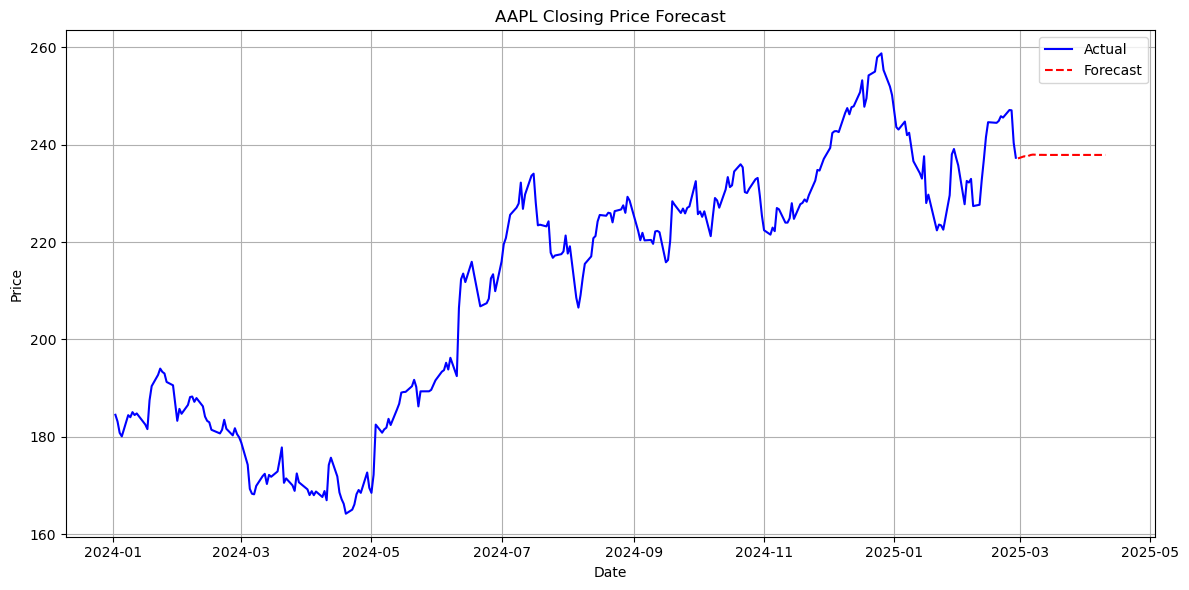

Plot saved as AAPL_forecast_plot.png


In [12]:
# Step 7: Plot Actual vs Forecasted Close Prices
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label='Actual', color='blue')
plt.plot(forecast_index, forecast.values, label='Forecast', color='red', linestyle='--')
plt.title(f"{ticker} Closing Price Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plot_filename = f"{ticker}_forecast_plot.png"
plt.savefig(plot_filename)
plt.show()
print(f'Plot saved as {plot_filename}')


In [13]:
!pip3 install yfinance pandas matplotlib statsmodels snscrape nltk vaderSentiment


StatementMeta(69af5b35-48d0-49fe-8597-e33f401a392d, 2, 18, Finished, Available, Finished)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 27.7 MB/s eta 0:00:00


In [14]:
import pandas as pd
import snscrape.modules.twitter as sntwitter
import requests
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import datetime, timedelta


StatementMeta(69af5b35-48d0-49fe-8597-e33f401a392d, 2, 19, Finished, Available, Finished)

In [15]:
def fetch_mock_headlines(ticker, num_days=5):
    today = datetime.today().date()
    headlines = []
    for i in range(num_days):
        date = today - timedelta(days=i)
        headlines.append({
            "source": "Yahoo Finance",
            "title": f"{ticker} stock performance discussed by analysts on {date}",
            "text": f"{ticker} shows strong investor confidence and potential growth.",
            "date": date
        })
    return headlines


StatementMeta(69af5b35-48d0-49fe-8597-e33f401a392d, 2, 20, Finished, Available, Finished)

In [16]:
def analyze_sentiment(text_list):
    analyzer = SentimentIntensityAnalyzer()
    return [analyzer.polarity_scores(text)["compound"] for text in text_list]


StatementMeta(69af5b35-48d0-49fe-8597-e33f401a392d, 2, 21, Finished, Available, Finished)

In [23]:


from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, lit
from pyspark.sql.types import StructType, StructField, StringType, DateType, FloatType
from datetime import datetime, timedelta
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# 1. Create Spark session
spark = SparkSession.builder.getOrCreate()

# 2. Parameters
ticker = "AAPL"
num_days = 5
today = datetime.today().date()

# 3. Create raw mock data directly in Spark (no Pandas at all)
raw_data = []
for i in range(num_days):
    dt = today - timedelta(days=i)
    raw_data.append((
        "Yahoo Finance",
        f"{ticker} stock analysis for {dt}",
        f"{ticker} shows promising signs of recovery and growth potential.",
        str(dt)
    ))

schema = StructType([
    StructField("source", StringType(), True),
    StructField("title", StringType(), True),
    StructField("text", StringType(), True),
    StructField("date", StringType(), True)
])

sdf = spark.createDataFrame(raw_data, schema)

# 4. Define fast UDF for sentiment analysis (with pre-initialized VADER)
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    return float(analyzer.polarity_scores(text)["compound"])

sentiment_udf = udf(analyze_sentiment, FloatType())

# 5. Apply sentiment UDF
sdf = sdf.withColumn("sentiment", sentiment_udf(sdf["text"]))

# 6. Add ticker column and show results
sdf = sdf.withColumn("ticker", lit(ticker))
sdf.show(truncate=False)


StatementMeta(69af5b35-48d0-49fe-8597-e33f401a392d, 2, 28, Finished, Cancelled, Cancelled)

In [19]:
from azureml.core import Workspace, Datastore

# Load workspace config (auto if you're running inside Azure ML)
ws = Workspace.from_config()

# Get the default blob datastore
datastore = ws.get_default_datastore()

# Upload the CSV
datastore.upload_files(
    files=[csv_name],                      
    target_path='sentimentdata/',         
    overwrite=True
)

print(f"Uploaded {csv_name} to Azure Blob in 'sentimentdata/' container.")


StatementMeta(, , -1, Waiting, , Waiting)

In [20]:
# Step: Load Sentiment CSV
sentiment_df = pd.read_csv(f"{ticker}_news_sentiment.csv")

# Ensure date format match
sentiment_df["date"] = pd.to_datetime(sentiment_df["date"])
data.index = pd.to_datetime(data.index)

# Step: Merge with historical price data
stock_sentiment = pd.merge(
    data,
    sentiment_df[["date", "sentiment"]],
    left_index=True,
    right_on="date",
    how="left"
)

stock_sentiment.set_index("date", inplace=True)
print("✅ Combined DataFrame with Sentiment + Stock Data")
stock_sentiment.tail()


StatementMeta(, , -1, Waiting, , Waiting)